# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'additional_featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [3]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

# MEGNO

In [4]:
features = ['MEGNO']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.84484394                                          
ERROR                                               
0.0074393150201747926                               
SCORE:                                                                        
0.8421723199999999                                                            
ERROR                                                                         
0.004886602137867676                                                          
SCORE:                                                                        
0.80630442                                                                    
ERROR                                                                         
0.0043388131633751315                                                         
SCORE:                                                                        
0.8477456999999999                                                           

SCORE:                                                                         
0.8448920399999998                                                             
ERROR                                                                          
0.004799754445578317                                                           
SCORE:                                                                         
0.8455425799999998                                                             
ERROR                                                                          
0.008428113656848634                                                           
SCORE:                                                                         
0.84744502                                                                     
ERROR                                                                          
0.00781403728583093                                                            
SCORE:                                  

In [6]:
best

{'x_learning_rate': 0.13527846760601117,
 'x_max_depth': 4,
 'x_min_child': 6.0,
 'x_pos_weight': 45.560241294806346,
 'x_subsample': 0.8328637344801604,
 'x_tree_colsample': 0.5829112408130519}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [7]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.837277+0.00501696	test-auc:0.830125+0.0100857
[1]	train-auc:0.846174+0.00291536	test-auc:0.838227+0.00531545
[2]	train-auc:0.848722+0.00257747	test-auc:0.840518+0.00804642
[3]	train-auc:0.849954+0.0022392	test-auc:0.84165+0.00779114
[4]	train-auc:0.850259+0.00227539	test-auc:0.841781+0.0074654
[5]	train-auc:0.851093+0.00218285	test-auc:0.842541+0.0073059
[6]	train-auc:0.85238+0.00252498	test-auc:0.844498+0.00794074
[7]	train-auc:0.854816+0.00183686	test-auc:0.846291+0.00698309
[8]	train-auc:0.855724+0.00188358	test-auc:0.847744+0.00655961
[9]	train-auc:0.855839+0.00191307	test-auc:0.847654+0.00667776


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5829112408130519, gamma=0,
              learning_rate=0.13527846760601117, max_delta_step=0, max_depth=4,
              min_child_weight=6.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=45.560241294806346,
              seed=None, silent=True, subsample=0.8328637344801604)

In [8]:
model.save_model(datapath+'../models/megno.bin')
dill.dump([model, features, featureargs, featurefolder], open(datapath+"../models/megno.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.854)')

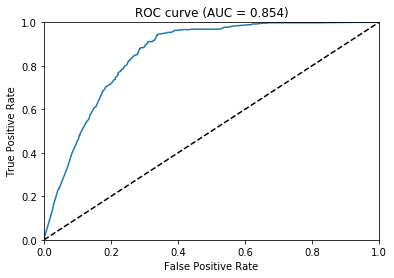

In [9]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# AMD

In [10]:
features = ['AMDtriofracnear', 'AMDtriofracfar']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.7107800400000001                                  
ERROR                                               
0.014161693766472383                                
SCORE:                                                                        
0.69676218                                                                    
ERROR                                                                         
0.013973267520111915                                                          
SCORE:                                                                        
0.690763                                                                      
ERROR                                                                         
0.019004530367468568                                                          
SCORE:                                                                        
0.7215800399999999                                                           

SCORE:                                                                         
0.72130312                                                                     
ERROR                                                                          
0.015363075240456516                                                           
SCORE:                                                                         
0.6888559200000001                                                             
ERROR                                                                          
0.012126391476928074                                                           
SCORE:                                                                         
0.69934498                                                                     
ERROR                                                                          
0.01351786115491925                                                            
SCORE:                                  

In [12]:
best

{'x_learning_rate': 0.19434304613623124,
 'x_max_depth': 3,
 'x_min_child': 3.0,
 'x_pos_weight': 17.77188900907022,
 'x_subsample': 0.8115795687387061,
 'x_tree_colsample': 0.7643458710377253}

In [13]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.679704+0.00509602	test-auc:0.669367+0.015963
[1]	train-auc:0.728661+0.0220742	test-auc:0.713131+0.0347427
[2]	train-auc:0.737376+0.00504035	test-auc:0.724477+0.0155146
[3]	train-auc:0.737691+0.00754712	test-auc:0.725555+0.0138723
[4]	train-auc:0.736201+0.00803513	test-auc:0.723717+0.0158753
[5]	train-auc:0.736344+0.00813727	test-auc:0.722858+0.0191462
[6]	train-auc:0.738145+0.0107858	test-auc:0.724182+0.0184817
[7]	train-auc:0.742295+0.00647462	test-auc:0.726406+0.01519
[8]	train-auc:0.743083+0.00780656	test-auc:0.72673+0.0149984
[9]	train-auc:0.743833+0.00907932	test-auc:0.727251+0.0168758


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7643458710377253, gamma=0,
              learning_rate=0.19434304613623124, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=17.77188900907022,
              seed=None, silent=True, subsample=0.8115795687387061)

In [14]:
model.save_model(datapath+'../models/AMD.bin')
dill.dump([model, features, featureargs, featurefolder], open(datapath+"../models/AMD.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.731)')

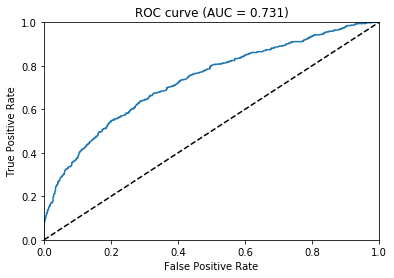

In [15]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# Hill

In [16]:
features = ['betanear', 'betafar']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.6929808                                           
ERROR                                               
0.01795402041738981                                 
SCORE:                                                                        
0.67464344                                                                    
ERROR                                                                         
0.01842240069527127                                                           
SCORE:                                                                        
0.6792827                                                                     
ERROR                                                                         
0.01082282838620357                                                           
SCORE:                                                                        
0.70676014                                                                   

0.01789011988890886                                                            
SCORE:                                                                         
0.7060164                                                                      
ERROR                                                                          
0.01574783121950022                                                            
SCORE:                                                                         
0.70700556                                                                     
ERROR                                                                          
0.01563315402926617                                                            
SCORE:                                                                         
0.69289566                                                                     
ERROR                                                                          
0.016527339022348504                    

In [18]:
best

{'x_learning_rate': 0.19920254046579614,
 'x_max_depth': 2,
 'x_min_child': 4.0,
 'x_pos_weight': 13.159685920910627,
 'x_subsample': 0.9211190570281913,
 'x_tree_colsample': 0.7488159420431533}

In [19]:
best

{'x_learning_rate': 0.19920254046579614,
 'x_max_depth': 2,
 'x_min_child': 4.0,
 'x_pos_weight': 13.159685920910627,
 'x_subsample': 0.9211190570281913,
 'x_tree_colsample': 0.7488159420431533}

In [20]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.66536+0.0038668	test-auc:0.661185+0.00448844
[1]	train-auc:0.715042+0.0214481	test-auc:0.70571+0.0186714
[2]	train-auc:0.720583+0.00520418	test-auc:0.711199+0.0111802
[3]	train-auc:0.721101+0.00659697	test-auc:0.711955+0.0174144
[4]	train-auc:0.717294+0.0075326	test-auc:0.709242+0.020086
[5]	train-auc:0.72147+0.00861725	test-auc:0.712375+0.0182064
[6]	train-auc:0.723624+0.00534701	test-auc:0.714166+0.0172506
[7]	train-auc:0.727959+0.0032518	test-auc:0.717696+0.0126114
[8]	train-auc:0.727241+0.00344409	test-auc:0.716504+0.0142674
[9]	train-auc:0.727773+0.00459865	test-auc:0.717217+0.0164712


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7488159420431533, gamma=0,
              learning_rate=0.19920254046579614, max_delta_step=0, max_depth=2,
              min_child_weight=4.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=13.159685920910627,
              seed=None, silent=True, subsample=0.9211190570281913)

In [21]:
model.save_model(datapath+'../models/hill.bin')
dill.dump([model, features, featureargs, featurefolder], open(datapath+"../models/hill.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.703)')

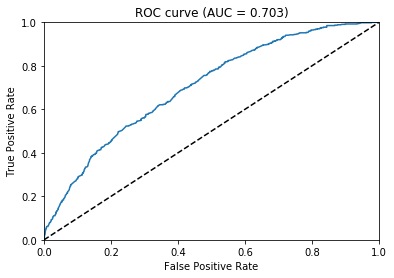

In [22]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# N-body

In [23]:
datapath = '../training_data/'
dset = 'resonant/'
featurefolder = 'shadowtimes/'
trainingdatafolder = datapath+dset+featurefolder
features=None

In [24]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [25]:
shadowstable = trainX['shadow_instability_time'] > 8.99e8

3% had stability in shadow integration disagree with nominal integration

In [26]:
(trainY != shadowstable).sum()/trainY.shape[0]

0.029128641080135017

In [27]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.6929808                                           
ERROR                                               
0.01795402041738981                                 
SCORE:                                                                        
0.67464344                                                                    
ERROR                                                                         
0.01842240069527127                                                           
SCORE:                                                                        
0.6792827                                                                     
ERROR                                                                         
0.01082282838620357                                                           
SCORE:                                                                        
0.70676014                                                                   

0.01789011988890886                                                            
SCORE:                                                                         
0.7060164                                                                      
ERROR                                                                          
0.01574783121950022                                                            
SCORE:                                                                         
0.70700556                                                                     
ERROR                                                                          
0.01563315402926617                                                            
SCORE:                                                                         
0.69289566                                                                     
ERROR                                                                          
0.016527339022348504                    

In [28]:
best

{'x_learning_rate': 0.19920254046579614,
 'x_max_depth': 2,
 'x_min_child': 4.0,
 'x_pos_weight': 13.159685920910627,
 'x_subsample': 0.9211190570281913,
 'x_tree_colsample': 0.7488159420431533}

In [29]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.66536+0.0038668	test-auc:0.661185+0.00448844
[1]	train-auc:0.715042+0.0214481	test-auc:0.70571+0.0186714
[2]	train-auc:0.720583+0.00520418	test-auc:0.711199+0.0111802
[3]	train-auc:0.721101+0.00659697	test-auc:0.711955+0.0174144
[4]	train-auc:0.717294+0.0075326	test-auc:0.709242+0.020086
[5]	train-auc:0.72147+0.00861725	test-auc:0.712375+0.0182064
[6]	train-auc:0.723624+0.00534701	test-auc:0.714166+0.0172506
[7]	train-auc:0.727959+0.0032518	test-auc:0.717696+0.0126114
[8]	train-auc:0.727241+0.00344409	test-auc:0.716504+0.0142674
[9]	train-auc:0.727773+0.00459865	test-auc:0.717217+0.0164712


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7488159420431533, gamma=0,
              learning_rate=0.19920254046579614, max_delta_step=0, max_depth=2,
              min_child_weight=4.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=13.159685920910627,
              seed=None, silent=True, subsample=0.9211190570281913)

In [30]:
model.save_model(datapath+'../models/nbody.bin')
dill.dump([model, features, featureargs, featurefolder], open(datapath+"../models/nbody.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.989)')

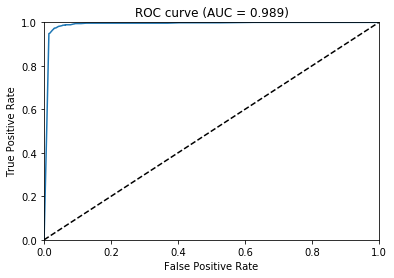

In [31]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))